In [15]:
#Install
!pip install trdg
!pip install Pillow==9.5.0

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [16]:
# Importing the matplotlib library's pyplot module for plotting and visualizing data.
import matplotlib.pyplot as plt

In [17]:
# Importing specific generator classes from the 'trdg' library
# These generators are used to create synthetic text images for training OCR models
from trdg.generators import (
    GeneratorFromDict,
    GeneratorFromRandom,
    GeneratorFromStrings,
    GeneratorFromWikipedia,
)


In [18]:
# Initializing a generator from strings. This generator will create images of text using the provided strings.
# 'blur' and 'random_blur' are arguments to add blur effects to the generated images, simulating variations in text clarity.
generator = GeneratorFromStrings(
    ['Hello world!', 'This is Patrick', 'from Neuromatch'],
    blur=2,
    random_blur=True
)

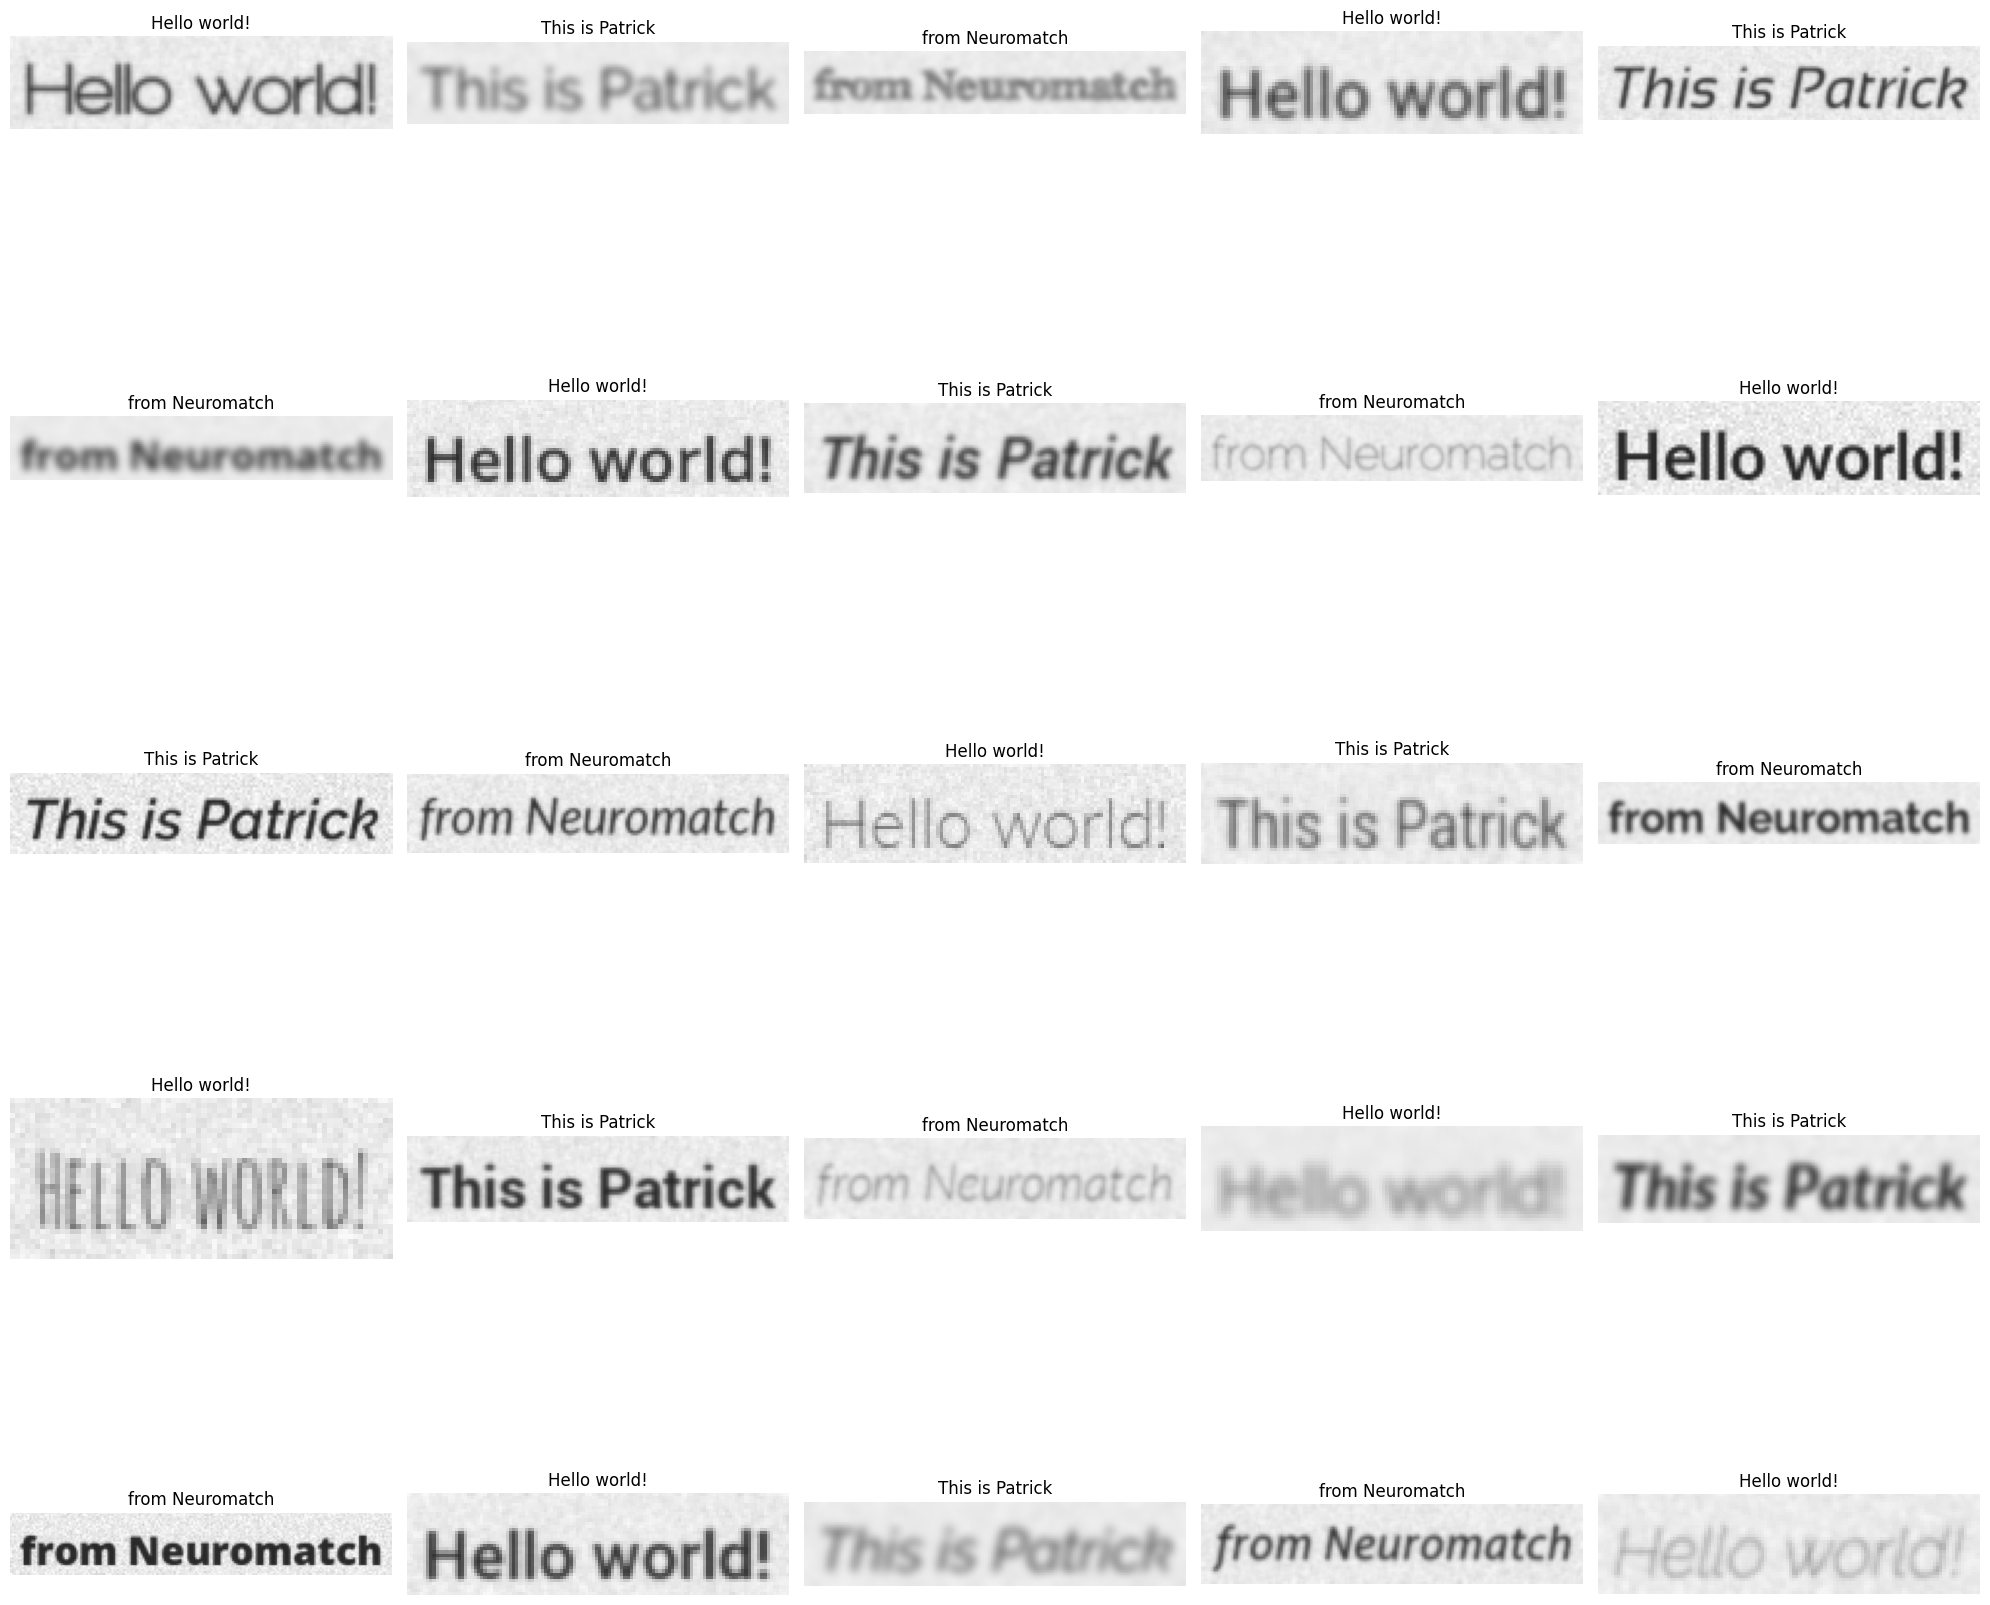

In [19]:
# Prepare to display images in a grid
fig, axs = plt.subplots(5, 5, figsize=(20, 20))  # Adjust grid size as needed
axs = axs.flatten()

# Generate and display 25 images
for i in range(25):
    img, lbl = next(generator)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(lbl)

plt.tight_layout()
plt.show()

In [20]:
from IPython.display import IFrame

IFrame("https://www.calligrapher.ai/", width=800, height=600)